**DATA DESCRIPTION**

PLAYERS

The dataset consists of characteristics of players in the Minecraft server. It consists of 198 observations and 7 variables:
- experience (chr)
    - The player's experience level, consisting of: Amateur, Beginner, Regular, Veteran, and Pro.
- subscribe (lgl)
    - Whether or not the player is subscribed to the game newsletter, can be TRUE or FALSE.
- hashedEmail (chr)
    - The player's hashed email.
- played_hours (dbl)
    - The number of hours the player has played in this Minecraft server.
    - A potential issue with the way this data was collected is that it only represents the number of hours the player has played in this specific server, and is not representative of their total number of hours played, which can lead to an inaccurate representation of their commitment.
    - summary statistics:
        - min: 0.00
        - max: 223.10
        - 1st quartile: 0.00
        - 3rd quartile: 0.60
        - median: 0.10
- name (chr)
    - The player's first name.
- gender (chr)
    - The player's gender, can be Male, Female, Non-binary, Two-spirited, Agender, Prefer not to say, or Other.
    - The "Prefer not to say" values pose a potential issue when deciding whether or to treat them as NA values or as their own category.
- Age (dbl)
    - The player's age in years.
    - This column contains some NA values, which will need to be removed when performing data manipulation and analysis.
    - summary statistics:
        - min: 9.00
        - max: 58.00
        - 1st quartile: 17.00
        - 3rd quartile: 19.00
        - median: 19.00

SESSIONS

The dataset consists of data on individual play session by each player on the Minecraft server. It consists of 1535
observations and 5 variables:
- hashedEmail (chr)
    - The player's hashed email.
- start_time (chr)
    - The start time of the session.
- end_time (chr)
    - The end time of the session.
- original_start_time (dbl)
    - The start time of the session in Unix Epoch date format.
- original_end_time (dbl)
    - The end time of the session in Unix Epoch date format.

The start_time and end_time columns pose an issue because there are too many variables within 1 column (day, month, year, and time), so wrangling will need to be performed to make the data tidy.


In [34]:
library(tidyverse)
library(repr)

players <- read_csv("data/players.csv")
players_summary <- players |>
    summarize(min_hours = min(played_hours),
              Q1_hours = quantile(played_hours, 0.25),
              median_hours = median(played_hours),
              Q2_hours = quantile(played_hours, 0.75),
              max_hours = max(played_hours),
              min_age = min(Age, na.rm = TRUE),
              Q1_age = quantile(Age, 0.25, na.rm = TRUE),
              median_age = median(Age, na.rm = TRUE),
              Q2_age = mean(Age, 0.75, na.rm = TRUE),
              max_age = max(Age, na.rm = TRUE))
players_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


min_hours,Q1_hours,median_hours,Q2_hours,max_hours,min_age,Q1_age,median_age,Q2_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0.1,0.6,223.1,9,17,19,19,58


**QUESTIONS**

The broad question I will be addressing is: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?" Specifically, I want to answer the question: Can the number of hours played in the server and player age predict whether or not a player will subscribe to the newsletter in the players.csv dataset, and does this differ between amateur and pro players?

The variables "played_hours" and "Age" will be the predictor variables and "subscribe" will be the response variable. A knn-classification model can be used to address the question. Separate analyses can be performed on players with Amateur and Pro levels of experience to compare between the 2 player types.

**EXPLORATORY DATA ANALYSIS AND VISUALIZATION**

In [40]:
library(tidyverse)
library(repr)

#tidying data

players <- read_csv("data/players.csv")
players
sessions <- read_csv("data/sessions.csv") |>
    separate(start_time, into = c("start_date", "start_time_only"), sep = " ") |>
    separate(start_date, into = c("start_day", "start_month", "start_year"), sep = "/") |>
    separate(end_time, into = c("end_date", "end_time_only"), sep = " ") |>
    separate(end_date, into = c("end_day", "end_month", "end_year"), sep = "/") |>
    select(hashedEmail, 
           start_day, 
           start_month, 
           start_year, 
           start_time_only, 
           end_day, 
           end_month, 
           end_year, 
           end_time_only, 
           original_start_time, 
           original_end_time)
sessions

    

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_day,start_month,start_year,start_time_only,end_day,end_month,end_year,end_time_only,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30,06,2024,18:12,30,06,2024,18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17,06,2024,23:33,17,06,2024,23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25,07,2024,17:34,25,07,2024,17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25,07,2024,03:22,25,07,2024,03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25,05,2024,16:01,25,05,2024,16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23,06,2024,15:08,23,06,2024,17:10,1.71916e+12,1.71916e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15,04,2024,07:12,15,04,2024,07:21,1.71317e+12,1.71317e+12
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,21,09,2024,02:13,21,09,2024,02:30,1.72688e+12,1.72689e+12
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,21,06,2024,02:31,21,06,2024,02:49,1.71894e+12,1.71894e+12


In [38]:
# computing mean values

players_means <- players |>
    summarize(mean_played_hours = mean(played_hours),
              mean_age = mean(Age, na.rm = TRUE))
players_means

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,21.13918


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


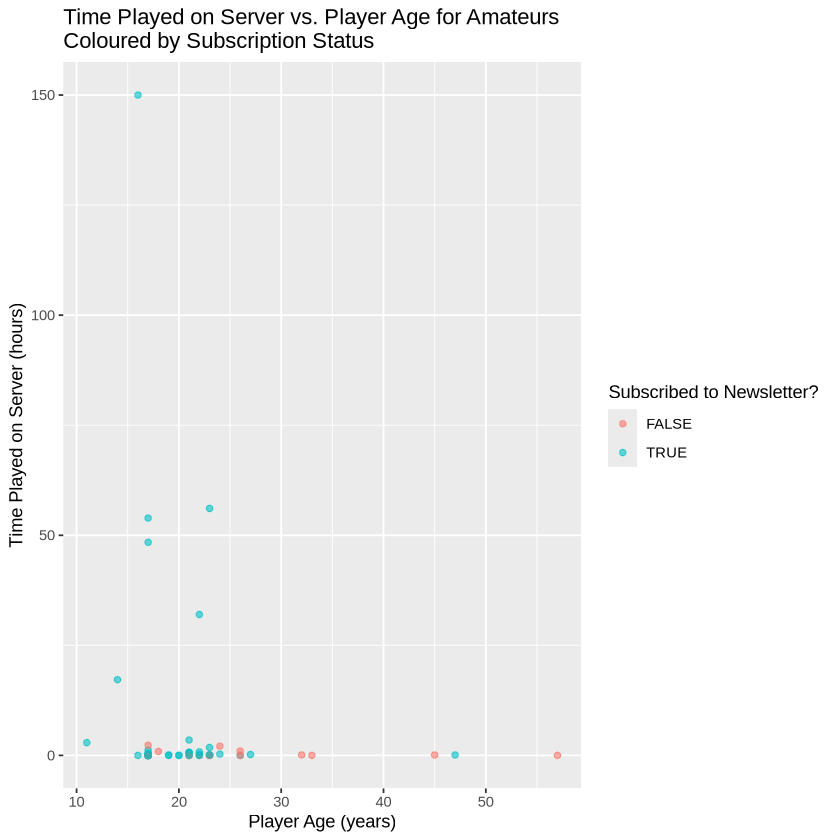

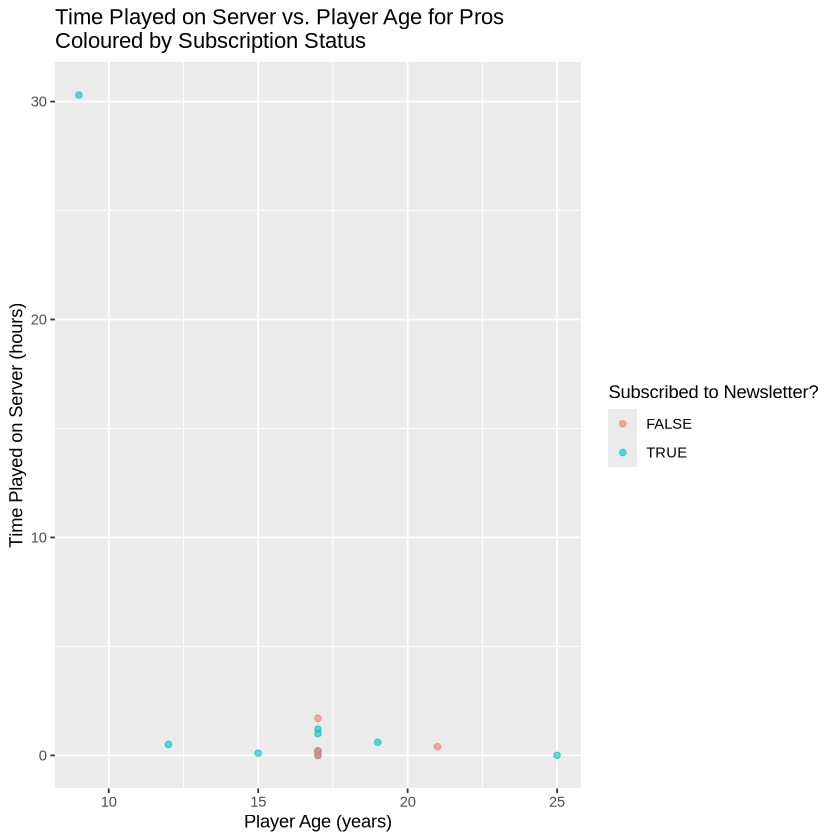

In [55]:
# exploratory visualizations

players_plot_amateur <- players |>
    filter(experience == "Amateur") |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Player Age (years)",
         y = "Time Played on Server (hours)",
         title = "Time Played on Server vs. Player Age for Amateurs\nColoured by Subscription Status",
         color = "Subscribed to Newsletter?")
players_plot_amateur
players_plot_pro <- players |>
    filter(experience == "Pro") |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Player Age (years)",
         y = "Time Played on Server (hours)",
         title = "Time Played on Server vs. Player Age for Pros\nColoured by Subscription Status",
         color = "Subscribed to Newsletter?")
players_plot_pro

The max amount of time played on the server is significantly higher for amateurs than it is for pros, which could be because pro players spend more time playing on other servers, and therefore this data would not be recorded in the dataset. Additionally, the max age is significantly higher for amateurs than it is for pros.

An issue could arise because the amount of players with pro levels of experience is quite small in this dataset, so there may not be enough data to adequately train a classification model.

The majority of data points in each graph are very close together, which could pose an issue with knn classification because the model will have a hard time distinguishing meaningful boundaries. This could potentialy cause the model to predict the majority class (subscribed) most of the time and perform poorly on outliers. Additionally, the 2 predictor variables vary greatly in their range size, so they will have to be scaled and centered before analysis can be performed.